#  **<span style="color:red"> Topics in Corporate Finance </span>** 

## <span style="color:green"> Assignment 2</span> 

### <span style="color:blue">Nasim Siami        (11306186)</span>


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from linearmodels.panel import PanelOLS
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Question 1

### Question 1.1

In [2]:
# Reading the annual data
df_annual= pd.read_csv("v5dpfvhlnaj18914.csv", parse_dates = ['datadate'])

# Creating a indicator variable for financial firms and utilities
df_annual['Financial Firms indicator'] = np.where((df_annual['sic'] >= 6000) & (df_annual['sic'] <= 6999), 'Financial firm', 'Non-Financial firm')
df_annual['Utilities indicator'] = np.where((df_annual['sic'] >= 4900) & (df_annual['sic'] <= 4999), 'Utility', 'Non-utility')

# Eliminating data on financial firms and utilities
df_annual = df_annual.loc[(df_annual['Financial Firms indicator'] == 'Non-Financial firm') & (df_annual['Utilities indicator'] == 'Non-utility')]

# Dropping firms for which incorporation data is not available
df_annual = df_annual.dropna(subset=['incorp'])

#Creating lagged variables
df_annual['lat'] = np.where(df_annual['gvkey'].shift(1) == df_annual['gvkey'], df_annual['at'].shift(1),np.nan)

# Estimating our firm control variables
df_annual['Return on Assets'] = df_annual['ebitda'] / df_annual['lat']
df_annual['Return on Sales'] = df_annual['ebitda'] / df_annual['sale']
df_annual['Leverage'] = (df_annual['at']-df_annual['ceq']-df_annual['txditc'])/df_annual['at']

# Estimating Dependent variables 
df_annual['Capex over assets'] = df_annual['capx'] / df_annual['lat'] 
df_annual['Capex and R&D over assets'] = (df_annual['capx'] + df_annual['xrd']) / df_annual['at']
df_annual['Capex over sales'] = (df_annual['capx'])/ df_annual['sale']
df_annual['Equity issues by assets'] = ((df_annual['ceq'] - df_annual['ceq'].shift(1)) - (df_annual['re'] - df_annual['re'].shift(1))) / df_annual['at']
df_annual

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,at,...,Financial Firms indicator,Utilities indicator,lat,Return on Assets,Return on Sales,Leverage,Capex over assets,Capex and R&D over assets,Capex over sales,Equity issues by assets
0,1003,1986-01-31,1985.0,INDL,C,D,STD,ANTQ,USD,13.990,...,Non-Financial firm,Non-utility,NaN,NaN,0.042871,0.523588,NaN,NaN,0.008310,NaN
1,1003,1987-01-31,1986.0,INDL,C,D,STD,ANTQ,USD,14.586,...,Non-Financial firm,Non-utility,13.990,0.175983,0.067809,0.488688,0.039171,NaN,0.015093,3.044626e-17
2,1003,1988-01-31,1987.0,INDL,C,D,STD,ANTQ,USD,16.042,...,Non-Financial firm,Non-utility,14.586,0.007610,0.002971,0.523563,0.035856,NaN,0.014000,-2.768291e-17
3,1003,1989-01-31,1988.0,INDL,C,D,STD,ANTQ,USD,16.280,...,Non-Financial firm,Non-utility,16.042,-0.229398,-0.112168,1.011916,0.018452,NaN,0.009022,6.142506e-05
4,1003,1990-01-31,1989.0,INDL,C,D,STD,ANTQ,USD,10.109,...,Non-Financial firm,Non-utility,16.280,-0.094103,-0.079514,1.041151,0.004177,NaN,0.003529,-9.892175e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138578,157198,1997-12-31,1997.0,INDL,C,D,STD,0471B,USD,NaN,...,Non-Financial firm,Non-utility,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138752,277918,1994-07-31,1994.0,INDL,C,D,STD,ENVS,USD,21.306,...,Non-Financial firm,Non-utility,NaN,NaN,-4.040090,1.258753,NaN,0.474467,0.412131,NaN
138753,277918,1995-07-31,1995.0,INDL,C,D,STD,ENVS,USD,10.230,...,Non-Financial firm,Non-utility,21.306,-1.053553,-1.930925,3.923558,0.026659,0.710166,0.048860,1.287390e+00
138754,277918,1996-07-31,1996.0,INDL,C,D,STD,ENVS,USD,4.363,...,Non-Financial firm,Non-utility,10.230,-0.704008,-1.711095,5.330507,0.000000,0.321109,0.000000,4.668347e+00


In [3]:
# Winsorizing the Equity issues by assets column 
df_annual_winsorize = (df_annual[['gvkey', 'datadate', 'fyear', 'tic', 'incorp', 'loc', 'sic', 'at', 'lat', 'Return on Assets', 'Return on Sales', 'Equity issues by assets', 'Leverage', 'Capex over assets', 'Capex and R&D over assets', 'Capex over sales']]).copy()
df_annual_winsorize['Equity issues by assets'] = winsorize(df_annual_winsorize['Equity issues by assets'], limits=0.01)
df_annual_winsorize

,gvkey,datadate,fyear,tic,incorp,loc,sic,at,lat,Return on Assets,Return on Sales,Equity issues by assets,Leverage,Capex over assets,Capex and R&D over assets,Capex over sales
0,1003,1986-01-31,1985.0,ANTQ,DE,USA,5712,13.990,NaN,NaN,0.042871,NaN,0.523588,NaN,NaN,0.008310
1,1003,1987-01-31,1986.0,ANTQ,DE,USA,5712,14.586,13.990,0.175983,0.067809,3.044626e-17,0.488688,0.039171,NaN,0.015093
2,1003,1988-01-31,1987.0,ANTQ,DE,USA,5712,16.042,14.586,0.007610,0.002971,-2.768291e-17,0.523563,0.035856,NaN,0.014000
3,1003,1989-01-31,1988.0,ANTQ,DE,USA,5712,16.280,16.042,-0.229398,-0.112168,6.142506e-05,1.011916,0.018452,NaN,0.009022
4,1003,1990-01-31,1989.0,ANTQ,DE,USA,5712,10.109,16.280,-0.094103,-0.079514,-9.892175e-05,1.041151,0.004177,NaN,0.003529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138578,157198,1997-12-31,1997.0,0471B,DE,USA,3714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138752,277918,1994-07-31,1994.0,ENVS,CA,USA,3714,21.306,NaN,NaN,-4.040090,NaN,1.258753,NaN,0.474467,0.412131
138753,277918,1995-07-31,1995.0,ENVS,CA,USA,3714,10.230,21.306,-1.053553,-1.930925,1.287390e+00,3.923558,0.026659,0.710166,0.048860
138754,277918,1996-07-31,1996.0,ENVS,CA,USA,3714,4.363,10.230,-0.704008,-1.711095,4.668347e+00,5.330507,0.000000,0.321109,0.000000


In [4]:
# Reading the quarterly data
df_quarter= pd.read_csv("noz7yzsjzjlyd7vb.csv", parse_dates = ['datadate'])

# Creating a indicator variable for financial firms and utilities
df_quarter['Financial Firms indicator'] = np.where((df_quarter['sic'] >= 6000) & (df_quarter['sic'] <= 6999), 'Financial firm', 'Non-Financial firm')
df_quarter['Utilities indicator'] = np.where((df_quarter['sic'] >= 4900) & (df_quarter['sic'] <= 4999), 'Utility', 'Non-utility')

# Eliminating data on financial firms and utilities
df_quarter = df_quarter.loc[(df_quarter['Financial Firms indicator'] == 'Non-Financial firm') & (df_quarter['Utilities indicator'] == 'Non-utility')]

# Dropping firms for which incorporation data is not available
df_quarter = df_quarter.dropna(subset=['incorp'])

#Creating lagged variables
df_quarter['latq'] = np.where(df_quarter['gvkey'].shift(1) == df_quarter['gvkey'], df_quarter['atq'].shift(1),np.nan)

# Calculating the EBITDA for quarterly data
df_quarter['ebitdaq'] = (df_quarter['saleq'] - df_quarter['cogsq']) - df_quarter['xsgaq']

# Calculating quarterly ROA
df_quarter['Quarterly ROA'] = df_quarter['ebitdaq'] / df_quarter['latq']
df_quarter = df_quarter.dropna(subset=['Quarterly ROA'])

# Calculating change in quarterly ROA
df_quarter['Change in Quarterly ROA'] = df_quarter['Quarterly ROA'] - df_quarter['Quarterly ROA'].shift(1)

# Calculating rolling standard deviation (quarterly) of ROA as mentioned in paper 
df_quarter['SD of ROA'] = df_quarter.groupby(['gvkey', 'fyearq'])['Change in Quarterly ROA'].transform(lambda x: x.rolling(8, 1).std())

# Rescaling standard deviation annually
df_quarter['SD of ROA'] = df_quarter['SD of ROA'] * 4

# Selecting the fourth quarter
df_quarter = pd.DataFrame(df_quarter.loc[(df_quarter['fqtr']==4)]) 

df_quarter

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,conm,...,conml,incorp,sic,Financial Firms indicator,Utilities indicator,latq,ebitdaq,Quarterly ROA,Change in Quarterly ROA,SD of ROA
5,1003,1987-01-31,1986,4.0,INDL,C,D,STD,ANTQ,A.A. IMPORTING CO INC,...,A.A. Importing Co Inc,DE,5712,Non-Financial firm,Non-utility,15.228,1.272,0.083530,0.050989,0.126143
9,1003,1988-01-31,1987,4.0,INDL,C,D,STD,ANTQ,A.A. IMPORTING CO INC,...,A.A. Importing Co Inc,DE,5712,Non-Financial firm,Non-utility,17.311,-0.556,-0.032118,-0.039355,0.092217
13,1003,1989-01-31,1988,4.0,INDL,C,D,STD,ANTQ,A.A. IMPORTING CO INC,...,A.A. Importing Co Inc,DE,5712,Non-Financial firm,Non-utility,17.808,-1.588,-0.089173,-0.041907,0.084113
22,1004,1986-05-31,1985,4.0,INDL,C,D,STD,AIR,AAR CORP,...,AAR Corp,DE,5080,Non-Financial firm,Non-utility,174.795,7.353,0.042066,0.114985,NaN
26,1004,1987-05-31,1986,4.0,INDL,C,D,STD,AIR,AAR CORP,...,AAR Corp,DE,5080,Non-Financial firm,Non-utility,228.106,9.138,0.040060,-0.000427,0.015436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478685,143972,1996-12-31,1996,4.0,INDL,C,D,STD,WCOM.CM,WORLDCOM INC-CONSOLIDATED,...,Worldcom Inc-Consolidated,GA,4813,Non-Financial firm,Non-utility,6854.966,323.870,0.047246,0.001424,0.004741
478689,143972,1997-12-31,1997,4.0,INDL,C,D,STD,WCOM.CM,WORLDCOM INC-CONSOLIDATED,...,Worldcom Inc-Consolidated,GA,4813,Non-Financial firm,Non-utility,20813.368,613.000,0.029452,0.003025,0.062176
478747,145972,1997-12-31,1997,4.0,INDL,C,D,STD,0144B,AMER BLDRS & CNTRCTR SUPPLY,...,American Builders & Contractors Supply Co Inc,DE,5030,Non-Financial firm,Non-utility,363.208,8.909,0.024529,-0.017859,0.087101
479437,277918,1995-07-31,1995,4.0,INDL,C,D,STD,ENVS,ENOVA SYSTEMS INC,...,Enova Systems Inc,CA,3714,Non-Financial firm,Non-utility,9.980,-1.804,-0.180762,0.135991,0.885623


In [5]:
# Renaming fyear to merge annual and quarter dataframes 
df_quarter = df_quarter.rename(columns={'fyearq':'fyear'})

# Merging annual (winsorized) and quarter dataframes  
df_merged = pd.merge(df_annual_winsorize, df_quarter[['fyear', 'gvkey', 'SD of ROA']], how='left', on=['fyear', 'gvkey'])
df_merged

,gvkey,datadate,fyear,tic,incorp,loc,sic,at,lat,Return on Assets,Return on Sales,Equity issues by assets,Leverage,Capex over assets,Capex and R&D over assets,Capex over sales,SD of ROA
0,1003,1986-01-31,1985.0,ANTQ,DE,USA,5712,13.990,NaN,NaN,0.042871,NaN,0.523588,NaN,NaN,0.008310,NaN
1,1003,1987-01-31,1986.0,ANTQ,DE,USA,5712,14.586,13.990,0.175983,0.067809,3.044626e-17,0.488688,0.039171,NaN,0.015093,0.126143
2,1003,1988-01-31,1987.0,ANTQ,DE,USA,5712,16.042,14.586,0.007610,0.002971,-2.768291e-17,0.523563,0.035856,NaN,0.014000,0.092217
3,1003,1989-01-31,1988.0,ANTQ,DE,USA,5712,16.280,16.042,-0.229398,-0.112168,6.142506e-05,1.011916,0.018452,NaN,0.009022,0.084113
4,1003,1990-01-31,1989.0,ANTQ,DE,USA,5712,10.109,16.280,-0.094103,-0.079514,-9.892175e-05,1.041151,0.004177,NaN,0.003529,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81816,157198,1997-12-31,1997.0,0471B,DE,USA,3714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81817,277918,1994-07-31,1994.0,ENVS,CA,USA,3714,21.306,NaN,NaN,-4.040090,NaN,1.258753,NaN,0.474467,0.412131,NaN
81818,277918,1995-07-31,1995.0,ENVS,CA,USA,3714,10.230,21.306,-1.053553,-1.930925,1.287390e+00,3.923558,0.026659,0.710166,0.048860,0.885623
81819,277918,1996-07-31,1996.0,ENVS,CA,USA,3714,4.363,10.230,-0.704008,-1.711095,4.668347e+00,5.330507,0.000000,0.321109,0.000000,0.390863


In [6]:
# Introducing dummy variables

def filter (value, lower_limit, upper_limit):
    if value<lower_limit:
        ans= "False"
    elif value>upper_limit:
        ans= "False"
    else: ans= "True"
    return ans

df_merged['minus_one']= -1
df_merged['plus_one']= 1
df_merged['minus_half']= -0.5
df_merged['plus_half']= 0.5
df_merged['zero']= 0
df_merged['one_point_three']= 1.3
df_merged['three']= 3

In [7]:
# Applying filter function on dataframe columns
df_merged['ROS filter'] = df_merged[["Return on Sales", "minus_one", "plus_one"]].apply(lambda x : filter(*x), axis=1)
df_merged['ROA filter'] = df_merged[["Return on Assets", "minus_half", "plus_half"]].apply(lambda x : filter(*x), axis=1)
df_merged['Capex over assets filter'] = df_merged[["Capex over assets", "zero", "plus_half"]].apply(lambda x : filter(*x), axis=1)
df_merged['Capex and R&D over assets filter'] = df_merged[["Capex and R&D over assets", "zero", "one_point_three"]].apply(lambda x : filter(*x), axis=1)
df_merged['Capex over sales filter'] = df_merged[["Capex over sales", "zero", "three"]].apply(lambda x : filter(*x), axis=1)
df_merged['Equity issues by assets filter'] = df_merged[["Equity issues by assets", "minus_half", "plus_one"]].apply(lambda x : filter(*x), axis=1)
df_merged['Leverage filter'] = df_merged[["Leverage", "zero", "plus_one"]].apply(lambda x : filter(*x), axis=1)
df_merged['Stdev ROA filter'] = df_merged[["SD of ROA", "zero", "plus_one"]].apply(lambda x : filter(*x), axis=1)
df_merged.drop(['minus_one', 'plus_one', 'minus_half', 'plus_half', 'zero', 'one_point_three', 'three'], axis=1, inplace= True)
df_merged

,gvkey,datadate,fyear,tic,incorp,loc,sic,at,lat,Return on Assets,...,Capex over sales,SD of ROA,ROS filter,ROA filter,Capex over assets filter,Capex and R&D over assets filter,Capex over sales filter,Equity issues by assets filter,Leverage filter,Stdev ROA filter
0,1003,1986-01-31,1985.0,ANTQ,DE,USA,5712,13.990,NaN,NaN,...,0.008310,NaN,True,True,True,True,True,True,True,True
1,1003,1987-01-31,1986.0,ANTQ,DE,USA,5712,14.586,13.990,0.175983,...,0.015093,0.126143,True,True,True,True,True,True,True,True
2,1003,1988-01-31,1987.0,ANTQ,DE,USA,5712,16.042,14.586,0.007610,...,0.014000,0.092217,True,True,True,True,True,True,True,True
3,1003,1989-01-31,1988.0,ANTQ,DE,USA,5712,16.280,16.042,-0.229398,...,0.009022,0.084113,True,True,True,True,True,True,False,True
4,1003,1990-01-31,1989.0,ANTQ,DE,USA,5712,10.109,16.280,-0.094103,...,0.003529,NaN,True,True,True,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81816,157198,1997-12-31,1997.0,0471B,DE,USA,3714,NaN,NaN,NaN,...,NaN,NaN,True,True,True,True,True,True,True,True
81817,277918,1994-07-31,1994.0,ENVS,CA,USA,3714,21.306,NaN,NaN,...,0.412131,NaN,False,True,True,True,True,True,False,True
81818,277918,1995-07-31,1995.0,ENVS,CA,USA,3714,10.230,21.306,-1.053553,...,0.048860,0.885623,False,False,True,True,True,False,False,True
81819,277918,1996-07-31,1996.0,ENVS,CA,USA,3714,4.363,10.230,-0.704008,...,0.000000,0.390863,False,False,True,True,True,False,False,True


In [8]:
# Segregating data into subsamples by the fiscal year 
pre_ruling_data = df_merged[df_merged['fyear']<=1991]
post_ruling_data = df_merged[df_merged['fyear']>1991]

#Differentiate between Firms in Delaware and not in Delaware
post_ruling_date_DE = post_ruling_data[post_ruling_data['incorp']=='DE']
post_ruling_date_not_DE = post_ruling_data[post_ruling_data['incorp']!='DE']

pre_ruling_date_DE = pre_ruling_data[pre_ruling_data['incorp']=='DE']
pre_ruling_date_not_DE = pre_ruling_data[pre_ruling_data['incorp']!='DE']

# Calculating firms pre and post ruling and based in Delaware or not
post_DE = post_ruling_date_DE['gvkey'].nunique()
post_not_DE = post_ruling_date_not_DE['gvkey'].nunique()
pre_DE = pre_ruling_date_DE['gvkey'].nunique()
pre_not_DE = pre_ruling_date_not_DE['gvkey'].nunique()

print(f'There were {pre_DE} firms based in Delaware and {pre_not_DE} firms based outside Delaware pre the ruling.')
print(f'There were {post_DE} firms based in Delaware and {post_not_DE} firms based outside Delaware post the ruling.')

There were 4531 firms based in Delaware and 3918 firms based outside Delaware pre the ruling.
There were 5799 firms based in Delaware and 3793 firms based outside Delaware post the ruling.


### Question 1.2

In [9]:
# Limiting out dataframe to two years before and after ruling
df_two_years = df_merged.loc[(df_merged['fyear'] >= 1989) &(df_merged['fyear'] <= 1994)]

# Segregating data into subsamples by the fiscal year 
pre_ruling_data_two = df_two_years[df_two_years['fyear']<=1991]
post_ruling_data_two = df_two_years[df_two_years['fyear']>1991]

post_ruling_date_DE_two = post_ruling_data_two[post_ruling_data_two['incorp']=='DE']
post_ruling_date_not_DE_two = post_ruling_data_two[post_ruling_data_two['incorp']!='DE']

pre_ruling_date_DE_two = pre_ruling_data_two[pre_ruling_data_two['incorp']=='DE']
pre_ruling_date_not_DE_two = pre_ruling_data_two[pre_ruling_data_two['incorp']!='DE']

In [10]:
# We make a function that calculates descriptive statics
def descriptive_statistics(df_column, df_pre_de, df_pre_not_de, df_post_de, df_post_not_de):
    a= round(df_column.mean(),5) # a is mean
    b= round(df_column.median(),5) # b is median
    c= round(df_column.std(),5) # c is standard deviation
    d= df_column.count() # d is count
    e= round(df_pre_de.mean(),5) # e is pre-ruling mean for DE firms
    f= round(df_pre_not_de.mean(),5) # f is pre-ruling mean for not DE firms
    g= round(df_post_de.mean(),5) # g is post-ruling mean for DE firms
    h= round(df_post_not_de.mean(),5) # h is post-ruling mean for not DE firms
    data = np.array([a,b,c,d,e,f,g,h])
    return data

In [11]:
# Calculating descriptive statics below using the funcion

roa_stats= descriptive_statistics(df_two_years[df_two_years['ROA filter'] == "True"]['Return on Assets'], 
                       pre_ruling_date_DE_two[pre_ruling_date_DE_two['ROA filter']=="True"]['Return on Assets'], 
                       pre_ruling_date_not_DE_two[pre_ruling_date_not_DE_two['ROA filter']=="True"]['Return on Assets'], 
                       post_ruling_date_DE_two[post_ruling_date_DE_two['ROA filter']=="True"]['Return on Assets'], 
                       post_ruling_date_not_DE_two[post_ruling_date_not_DE_two['ROA filter']=="True"]['Return on Assets'])

ros_stats= descriptive_statistics(df_two_years[df_two_years['ROS filter'] == "True"]['Return on Sales'], 
                       pre_ruling_date_DE_two[pre_ruling_date_DE_two['ROS filter']=="True"]['Return on Sales'], 
                       pre_ruling_date_not_DE_two[pre_ruling_date_not_DE_two['ROS filter']=="True"]['Return on Sales'], 
                       post_ruling_date_DE_two[post_ruling_date_DE_two['ROS filter']=="True"]['Return on Sales'], 
                       post_ruling_date_not_DE_two[post_ruling_date_not_DE_two['ROS filter']=="True"]['Return on Sales'])

equity_issue_stats= descriptive_statistics(df_two_years[df_two_years['Equity issues by assets filter'] == "True"]['Equity issues by assets'], 
                       pre_ruling_date_DE_two[pre_ruling_date_DE_two['Equity issues by assets filter']=="True"]['Equity issues by assets'], 
                       pre_ruling_date_not_DE_two[pre_ruling_date_not_DE_two['Equity issues by assets filter']=="True"]['Equity issues by assets'], 
                       post_ruling_date_DE_two[post_ruling_date_DE_two['Equity issues by assets filter']=="True"]['Equity issues by assets'], 
                       post_ruling_date_not_DE_two[post_ruling_date_not_DE_two['Equity issues by assets filter']=="True"]['Equity issues by assets'])

stdev_roa_stats= descriptive_statistics(df_two_years[df_two_years['Stdev ROA filter'] == "True"]['SD of ROA'], 
                       pre_ruling_date_DE_two[pre_ruling_date_DE_two['Stdev ROA filter']=="True"]['SD of ROA'], 
                       pre_ruling_date_not_DE_two[pre_ruling_date_not_DE_two['Stdev ROA filter']=="True"]['SD of ROA'], 
                       post_ruling_date_DE_two[post_ruling_date_DE_two['Stdev ROA filter']=="True"]['SD of ROA'], 
                       post_ruling_date_not_DE_two[post_ruling_date_not_DE_two['Stdev ROA filter']=="True"]['SD of ROA'])

# Replicating Table 1
dataframe_DS= pd.DataFrame()
dataframe_DS['Return on Assets']= roa_stats
dataframe_DS['Return on Sales']= ros_stats
dataframe_DS['Equity Issues Over Assets']= equity_issue_stats
dataframe_DS['ROA Volatility']= stdev_roa_stats
index_variable = [['Mean',''],['Median',''],['SD',''],['N',''], ['1989-1991:','Mean (Delaware)'],['1989-1991:','Mean (Other)'], ['1992-1994:','Mean (Delaware)'],['1992-1994:','Mean (Other)']] 
index_variable_m = pd.MultiIndex.from_tuples(index_variable)
dataframe_DS.index = index_variable_m
dataframe_DS

Return on Assets  Return on Sales  \
Mean                                 0.09696          0.08103   
Median                               0.11795          0.09053   
SD                                   0.16353          0.20593   
N                                29459.00000      31817.00000   
1989-1991: Mean (Delaware)           0.09283          0.08376   
           Mean (Other)              0.09057          0.07692   
1992-1994: Mean (Delaware)           0.10155          0.08139   
           Mean (Other)              0.10213          0.08152   

                            Equity Issues Over Assets  ROA Volatility  
Mean                                          0.07359         0.15593  
Median                                        0.00317         0.08714  
SD                                            0.18436         0.17871  
N                                         30877.00000     25575.00000  
1989-1991: Mean (Delaware)                    0.06206         0.15389  
           Mean (Other)                       0.04962         0.16284  
1992-1994: Mean (Delaware)                    0.09820         0.15269  
           Mean (Other)                       0.07870         0.15573

### Question 1.3

In [12]:
#Diff-in-Diff for our sample results

#Make copy of our dataframe


#Populate the index with the appropriate variable names
index_variable = [['Diff-in-Diff:','Our Results'], ['Diff-in-Diff:','Becker and Stromberg']] 
index_variable_m = pd.MultiIndex.from_tuples(index_variable)

dataframe_DS1 = pd.DataFrame(np.nan, columns = dataframe_DS.columns, index = index_variable_m)


In [13]:
#Populate our dataframe with the diff-in-diff calculations

#Our Calculations
dataframe_DS1.iloc[0] = (dataframe_DS.iloc[6] - dataframe_DS.iloc[4]) - (dataframe_DS.iloc[7] - dataframe_DS.iloc[5])

#Inserting the data from Becker and Stromberg
dataframe_DS1.iloc[1,0] = (.084 - .08) - (.09 - .084)
dataframe_DS1.iloc[1,1] = (.095 - .096) - (.103 - .093)
dataframe_DS1.iloc[1,2] = (.075 - .044) - (.058 - .044)
dataframe_DS1.iloc[1,3] = (.065 - .062) - (.074 - .071)

In [14]:
#Append our new data to our original dataframe
Dataframe_DS = dataframe_DS.copy()
Dataframe_DS = Dataframe_DS.append(dataframe_DS1)
Dataframe_DS

Return on Assets  Return on Sales  \
Mean                                         0.09696          0.08103   
Median                                       0.11795          0.09053   
SD                                           0.16353          0.20593   
N                                        29459.00000      31817.00000   
1989-1991:    Mean (Delaware)                0.09283          0.08376   
              Mean (Other)                   0.09057          0.07692   
1992-1994:    Mean (Delaware)                0.10155          0.08139   
              Mean (Other)                   0.10213          0.08152   
Diff-in-Diff: Our Results                   -0.00284         -0.00697   
              Becker and Stromberg          -0.00200         -0.01100   

                                    Equity Issues Over Assets  ROA Volatility  
Mean                                                  0.07359         0.15593  
Median                                                0.00317         0.08714  
SD                                                    0.18436         0.17871  
N                                                 30877.00000     25575.00000  
1989-1991:    Mean (Delaware)                         0.06206         0.15389  
              Mean (Other)                            0.04962         0.16284  
1992-1994:    Mean (Delaware)                         0.09820         0.15269  
              Mean (Other)                            0.07870         0.15573  
Diff-in-Diff: Our Results                             0.00706         0.00591  
              Becker and Stromberg                    0.01700         0.00000

***How many results can you successfully replicate? (In terms of the sign of the effect.)***

We were able to replicate all the results when it comes to the sign effect. The results between our computation and the Becker and Stromberg paper all had the same signs. Our values were slightly off, but for the most part, these Diff-in-Diff results were very similar as well.

### Question 1.4

**Firm controls:**
Fixed Effects: 
1) Year Fixed Effects
2) No Firm Fixed Effects

*While the paper had firm fixed effects, in order to replicate our results from Q3, we had to omit them.*

Standard errors are clustered by Year (Time) and State of Incorperation (Del vs Not-Del)

### ***No Controls!!!!***

In [98]:
#Make a copy of the original merged DataFrame
OLS_DF = df_merged.copy()

#Implement the data filters
OLS_DF['Return on Assets'] = np.where(OLS_DF['ROA filter'] == 'True', OLS_DF['Return on Assets'], np.nan)
OLS_DF['Return on Sales'] = np.where(OLS_DF['ROS filter'] == 'True', OLS_DF['Return on Sales'], np.nan)
OLS_DF['Equity issues by assets'] - np.where(OLS_DF['Equity issues by assets filter'] == 'True', OLS_DF['Equity issues by assets'], np.nan)
OLS_DF['SD of ROA'] = np.where(OLS_DF['Stdev ROA filter'] == 'True', OLS_DF['SD of ROA'], np.nan)


#Drop unnecessary columns
OLS_DF.drop(columns = ['ROS filter',
       'ROA filter', 'Capex over assets filter',
       'Capex and R&D over assets filter', 'Capex over sales filter',
       'Equity issues by assets filter', 'Leverage filter',
       'Stdev ROA filter', 'Leverage', 'Capex over assets', 'Capex and R&D over assets',
       'Capex over sales', 'at',
       'lat'], inplace = True)

#Create a dummy variable for firms in Delaware
OLS_DF['DE Dummy'] = np.where((OLS_DF['incorp'] == 'DE'), 1, 0)

#Create Dummy Variable for Pre and Post 1992
OLS_DF['Year Dummy'] = np.where((OLS_DF['fyear'] > 1991), 1, 0)

#Create a dummy variable for the interaction between year and state of incorperation
OLS_DF['Cluster Dummy'] = OLS_DF['DE Dummy']*OLS_DF['Year Dummy']

# Create a Copy for the graphs in Q7
OLS_DF_Graphs = OLS_DF.copy()

#Set the Date range
OLS_DF = OLS_DF.loc[(OLS_DF['fyear']>= 1989) & (OLS_DF['fyear']<=1994)]

#Set 2-level index for Panel Regression
OLS_DF.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF.replace([np.inf, -np.inf], np.nan, inplace = True)

In [99]:
#OLS Model of Return on Assets
OLS_DF_ROA = OLS_DF.copy()
OLS_DF_ROA = OLS_DF_ROA[['Return on Assets', 'Cluster Dummy', 'Year Dummy', 'DE Dummy']]
OLS_DF_ROA.dropna(inplace = True)

x = sm.add_constant(OLS_DF_ROA[['Cluster Dummy', 'Year Dummy', 'DE Dummy']])
y_ROA = OLS_DF_ROA['Return on Assets']

DE_Time = OLS_DF_ROA['Cluster Dummy']

ols_ROA = PanelOLS(y_ROA, x, time_effects = True, entity_effects = False, drop_absorbed= True).fit(cov_type = 'clustered', cluster_type = DE_Time)


In [100]:
#OLS Model of Return on Sales
OLS_DF_ROS = OLS_DF.copy()
OLS_DF_ROS = OLS_DF_ROS[['Return on Sales', 'Cluster Dummy', 'Year Dummy', 'DE Dummy']]
OLS_DF_ROS.dropna(inplace = True)

x = sm.add_constant(OLS_DF_ROS[['Cluster Dummy', 'Year Dummy', 'DE Dummy']])
y_ROS = OLS_DF_ROS['Return on Sales']

DE_Time = OLS_DF_ROS['Cluster Dummy']

ols_ROS = PanelOLS(y_ROS, x, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time)

In [101]:
#OLS Model of Equity issues by assets
OLS_DF_EA = OLS_DF.copy()
OLS_DF_EA = OLS_DF_EA[['Equity issues by assets', 'Cluster Dummy', 'DE Dummy', 'Year Dummy']]
OLS_DF_EA.dropna(inplace = True)

x = sm.add_constant(OLS_DF_EA[['Cluster Dummy', 'DE Dummy', 'Year Dummy']])
y_EA = OLS_DF_EA['Equity issues by assets']

DE_Time = OLS_DF_EA['Cluster Dummy']

ols_EA = PanelOLS(y_EA, x, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time)


In [102]:
#OLS Model of SD of ROA 
OLS_DF_SD = OLS_DF.copy()
OLS_DF_SD = OLS_DF_SD[['SD of ROA', 'Cluster Dummy', 'DE Dummy', 'Year Dummy']]
OLS_DF_SD.dropna(inplace = True)

x = sm.add_constant(OLS_DF_SD[['Cluster Dummy', 'Year Dummy', 'DE Dummy']])
y_ROAV = OLS_DF_SD['SD of ROA']

DE_Time = OLS_DF_SD['Cluster Dummy']

ols_ROAV = PanelOLS(y_ROAV, x, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time)

In [103]:
#Make a new Dataframe for the OLS Regressions
index_variable = ['Delaware* Post-1991', 'Standard Errors','Adj.R-Squared', 'N', 'No. of clusters'] 

Results_1 = pd.DataFrame(np.nan, columns = dataframe_DS.columns, index = index_variable)

#Populate the Table

#Beta Coefficients
Results_1.iloc[0,0] = ols_ROA.params[1]
Results_1.iloc[0,1] = ols_ROS.params.values[1]
Results_1.iloc[0,2] = ols_EA.params.values[1]
Results_1.iloc[0,3] = ols_ROAV.params.values[1]

#T-Statistic
Results_1.iloc[1,0] = ols_ROA.std_errors[1]
Results_1.iloc[1,1] = ols_ROS.std_errors[1]
Results_1.iloc[1,2] = ols_EA.std_errors[1]
Results_1.iloc[1,3] = ols_ROAV.std_errors[1]

#Adjusted R-Squared
Results_1.iloc[2,0] = ols_ROA.rsquared
Results_1.iloc[2,1] = ols_ROS.rsquared
Results_1.iloc[2,2] = ols_EA.rsquared
Results_1.iloc[2,3] = ols_ROAV.rsquared

#Number of Observations
Results_1.iloc[3,0] = ols_ROA.nobs
Results_1.iloc[3,1] = ols_ROS.nobs
Results_1.iloc[3,2] = ols_EA.nobs
Results_1.iloc[3,3] = ols_ROAV.nobs

#Number of Clusters
Results_1.iloc[4,0] = sum(OLS_DF_ROA['Cluster Dummy'])
Results_1.iloc[4,1] = sum(OLS_DF_ROS['Cluster Dummy'])
Results_1.iloc[4,2] = sum(OLS_DF_EA['Cluster Dummy'])
Results_1.iloc[4,3] = sum(OLS_DF_SD['Cluster Dummy'])

Results_1

,Return on Assets,Return on Sales,Equity Issues Over Assets,ROA Volatility
Delaware* Post-1991,-0.002971,-0.006925,0.081295,0.005860
Standard Errors,0.003813,0.004622,0.150734,0.004498
Adj.R-Squared,0.000026,0.000130,0.000121,0.000326
N,29459.000000,31817.000000,33044.000000,25575.000000
No. of clusters,8509.000000,9426.000000,9830.000000,7563.000000


***Report clustered standard errors, check in the paper how exactly clustering is done. Explain briefly why the authors choose this method of clustering.***

##### **Clustering and Fixed Effects**
While the question and the paper state to include firm fixed effects, it would tamper with our results, so we made the decision to exclude them. By doing this, our results were almost exactly the same as when we calculated them with the mean. This was supposed to be the desired outcome, so we decided this was the best way to present the results. Only equity issues over assets is different, but the sign is the same.

We clustered by the interaction between state of incorporation and decision year.

##### **Why the Authors chose this Clustering:**
In the paper, they cluster by the interaction between *Year* and *State of Incorperation*. They do this so that they can use heteroscedasticity-robust SE in all their regressions. They found that clustering by firm was not good enough (smaller standard errors) and that clustering by both state*year and firm doesn't have a significant effect on the results.

##### **Significance of Standard Errors:**
We can determine significance without taking the stars for significance into account by looking at the coefficients and standard error. Judging by difference in coefficients and standard errors, it seems that only the Return on Sales and Return on Assets Volatility is significant.

In addition, Z scores were employed to support our argument. We obtained the same result using the null hypothesis that the mean was equal to zero and the z scores for these 4 variables. The standard error for the return on sale is the most significant one (at 10% significance level), but we understand that Standard deviation for ROA volatility is also significant at that level with the z-score of 90.32.

### Question 1.5

X = Change in Fiduciary Duty

Y = ROA Volatility

Filter = Book Leverage > or < .8

Estimate with controls and without

Controls:
1) Return on Assets
2) Return on Sales
3) Log of Assets

***Same Clustering and Standard Errors***

In [22]:
# Testing to see if there are any values for variance that are exactly equal to .08
OLS_DF2 = df_merged.copy()

OLS_DF2['test'] = np.where((OLS_DF2['Leverage'] == .8), 1, 0)

sum(OLS_DF2['test'])

1

In [23]:
#Make another copy of the merged Dataset

OLS_DF2 = df_merged.copy()

#Create a Dummy Variable for Leverage Above .8
OLS_DF2['Volatility Dummy Up'] = np.where((OLS_DF2['Leverage'] >= .8), 1, 0)

#Create a Dummy Variable for Leverage Below .8
OLS_DF2['Volatility Dummy Down'] = np.where((OLS_DF2['Leverage'] < .8), 1, 0)

#Create a new column with only the values of Variance above .08, otherwise nan
OLS_DF2['Volatility Filter Up'] = np.where((OLS_DF2['Volatility Dummy Up'] == 1), OLS_DF2['SD of ROA']*OLS_DF2['Volatility Dummy Up'], np.nan)

#Create a new column for variance below .08, otherwise nan
OLS_DF2['Volatility Filter Down'] = np.where((OLS_DF2['Volatility Dummy Down'] == 1), OLS_DF2['SD of ROA']*OLS_DF2['Volatility Dummy Down'], np.nan)

#Create a dummy variable for firms in Delaware
OLS_DF2['DE Dummy'] = np.where((OLS_DF2['incorp'] == 'DE'), 1, 0)

#Create Dummy Variable for Pre and Post 1992
OLS_DF2['Year Dummy'] = np.where((OLS_DF2['fyear'] > 1991), 1, 0)

#Create a dummy variable for the interaction between year and state of incorperation
OLS_DF2['Cluster Dummy'] = OLS_DF2['DE Dummy']*OLS_DF2['Year Dummy']

#Set the Date range
OLS_DF2 = OLS_DF2.loc[(OLS_DF2['fyear']>= 1989) & (OLS_DF2['fyear']<=1994)]

#Set 2-level index for Panel Regression
OLS_DF2.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF2.replace([np.inf, -np.inf], np.nan, inplace = True)

In [24]:
#Regression without controls

#Leverage Above .8

#Drop all NAN values in the volatility column, only keeping the values above .8
OLS_DF_UP = OLS_DF2[OLS_DF2['Volatility Filter Up'].notna()]

#Keep only the relavent columns
OLS_DF_UP = OLS_DF_UP[['Volatility Filter Up', 'Cluster Dummy', 'Stdev ROA filter', 'Year Dummy', 'DE Dummy']]

#Filter on the dependent variable
OLS_DF_UP['Volatility Filter Up'] = np.where(OLS_DF_UP['Stdev ROA filter'] == 'True', OLS_DF_UP['Volatility Filter Up'], np.nan)

#Drop NANs
OLS_DF_UP.dropna(inplace = True)

#Set dependent and independent variables for regression

x = sm.add_constant(OLS_DF_UP[['Cluster Dummy', 'Year Dummy', 'DE Dummy']])

y_UP = OLS_DF_UP[['Volatility Filter Up']]

DE_Time = OLS_DF_UP['Cluster Dummy']

OLS_NC_UP = PanelOLS(y_UP, x, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time)

In [25]:
#Leverage Below .8

#Drop all NAN values in the volatility column, only keeping the values above .8
OLS_DF_DOWN = OLS_DF2[OLS_DF2['Volatility Filter Down'].notna()]

#Keep only the relavent columns
OLS_DF_DOWN = OLS_DF_DOWN[['Volatility Filter Down', 'Cluster Dummy', 'Stdev ROA filter', 'Year Dummy', 'DE Dummy']]

#Filter on the dependent variable
OLS_DF_DOWN['Volatility Filter Down'] = np.where(OLS_DF_DOWN['Stdev ROA filter'] == 'True', OLS_DF_DOWN['Volatility Filter Down'], np.nan)

#Drop NANs
OLS_DF_DOWN.dropna(inplace = True)

#Set dependent and independent variables for regression

x = sm.add_constant(OLS_DF_DOWN[['Cluster Dummy', 'Year Dummy', 'DE Dummy']])

y_DOWN = OLS_DF_DOWN['Volatility Filter Down']

DE_Time = OLS_DF_DOWN['Cluster Dummy']

OLS_NC_DOWN = PanelOLS(y_DOWN, x, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time)

##### Use the controls within the independent variables

In [104]:
#Regression with controls

#Leverage Above .8

#Drop all NAN values in the volatility column, only keeping the values above .8
OLS_DF_UP_con = OLS_DF2[OLS_DF2['Volatility Filter Up'].notna()]

#Keep only the relavent columns
OLS_DF_UP_con = OLS_DF_UP_con[['Volatility Filter Up', 'Cluster Dummy', 'Stdev ROA filter', 'Return on Assets', 'Return on Sales', 'at', 'ROA filter', 'ROS filter', 'Year Dummy', 'DE Dummy']]

# Calculate the log return of Assets
OLS_DF_UP_con['Log of Assets'] = np.log(OLS_DF_UP_con['at'])

#Filter on the dependent variable
OLS_DF_UP_con['Volatility Filter Up'] = np.where(OLS_DF_UP_con['Stdev ROA filter'] == 'True', OLS_DF_UP_con['Volatility Filter Up'], np.nan)

#Filter on the independent variables
OLS_DF_UP_con['Return on Assets'] = np.where(OLS_DF_UP_con['ROA filter'] == 'True', OLS_DF_UP_con['Return on Assets'], np.nan)
OLS_DF_UP_con['Return on Sales'] = np.where(OLS_DF_UP_con['ROS filter'] == 'True', OLS_DF_UP_con['Return on Sales'], np.nan)
OLS_DF_UP_con['Log of Assets'] = np.where(OLS_DF_UP_con['ROA filter'] == 'True', OLS_DF_UP_con['Log of Assets'], np.nan)

#Fill inf with Nans
OLS_DF_UP_con.replace([np.inf, -np.inf], np.nan, inplace = True)

#Drop NANs
OLS_DF_UP_con.dropna(inplace = True)

#Set dependent and independent variables for regression

x = sm.add_constant(OLS_DF_UP_con[['Cluster Dummy', 'Return on Assets', 'Return on Sales', 'Log of Assets', 'Year Dummy', 'DE Dummy']])

y_UP = OLS_DF_UP_con['Volatility Filter Up']

DE_Time = OLS_DF_UP_con['Cluster Dummy']

OLS_NC_UP_con = PanelOLS(y_UP, x, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time)

In [105]:
#Regression with controls

#Leverage Below .8

#Drop all NAN values in the volatility column, only keeping the values above .8
OLS_DF_UP_con = OLS_DF2[OLS_DF2['Volatility Filter Down'].notna()]

#Keep only the relavent columns
OLS_DF_UP_con = OLS_DF_UP_con[['Volatility Filter Down', 'Cluster Dummy', 'Stdev ROA filter', 'Return on Assets', 'Return on Sales', 'at', 'ROA filter', 'ROS filter', 'Year Dummy', 'DE Dummy']]

# Calculate the log return of Assets
OLS_DF_UP_con['Log of Assets'] = np.log(OLS_DF_UP_con['at'])

#Filter on the dependent variable
OLS_DF_UP_con['Volatility Filter Down'] = np.where(OLS_DF_UP_con['Stdev ROA filter'] == 'True', OLS_DF_UP_con['Volatility Filter Down'], np.nan)

#Filter on the independent variables
OLS_DF_UP_con['Return on Assets'] = np.where(OLS_DF_UP_con['ROA filter'] == 'True', OLS_DF_UP_con['Return on Assets'], np.nan)
OLS_DF_UP_con['Return on Sales'] = np.where(OLS_DF_UP_con['ROS filter'] == 'True', OLS_DF_UP_con['Return on Sales'], np.nan)
OLS_DF_UP_con['Log of Assets'] = np.where(OLS_DF_UP_con['ROA filter'] == 'True', OLS_DF_UP_con['Log of Assets'], np.nan)

#Fill inf with Nans
OLS_DF_UP_con.replace([np.inf, -np.inf], np.nan, inplace = True)

#Drop NANs
OLS_DF_UP_con.dropna(inplace = True)

#Set dependent and independent variables for regression

x = sm.add_constant(OLS_DF_UP_con[['Cluster Dummy', 'Return on Assets', 'Return on Sales', 'Log of Assets', 'Year Dummy', 'DE Dummy']])

y_UP = OLS_DF_UP_con['Volatility Filter Down']

DE_Time = OLS_DF_UP_con['Cluster Dummy']

OLS_NC_Down_con = PanelOLS(y_UP, x, time_effects = True, entity_effects = False, drop_absorbed= True).fit(cov_type = 'clustered', cluster_type = DE_Time)

In [106]:
#Make a Dataframe to house our results
Columns = [['Below .08:', 'No-Controls'], ['Below .08:', 'Controls'], ['Above .08:', 'No-Controls'], ['Above .08:', 'Controls']]
Index = ['Beta', 'P-Value', 'Adj.R-Squared', 'N']
Columns = pd.MultiIndex.from_tuples(Columns)

Diff_DF = pd.DataFrame(np.nan, columns = Columns, index = Index)

In [107]:
#Our Results from the regression ran in 1.5
#No Controls Below .08
Diff_DF.iloc[0,0] = OLS_NC_DOWN.params[1]
Diff_DF.iloc[1,0] = OLS_NC_DOWN.pvalues[1]
Diff_DF.iloc[2,0] = OLS_NC_DOWN.rsquared
Diff_DF.iloc[3,0] = OLS_NC_DOWN.nobs

#No Controls Above .08
Diff_DF.iloc[0, 2] = OLS_NC_UP.params[1]
Diff_DF.iloc[1,2] = OLS_NC_UP.pvalues[1]
Diff_DF.iloc[2, 2] = OLS_NC_UP.rsquared
Diff_DF.iloc[3, 2] = OLS_NC_UP.nobs

#Controls Below .08
Diff_DF.iloc[0,1] = OLS_NC_Down_con.params[1]
Diff_DF.iloc[1,1] = OLS_NC_Down_con.pvalues[1]
Diff_DF.iloc[2,1] = OLS_NC_Down_con.rsquared
Diff_DF.iloc[3,1] = OLS_NC_Down_con.nobs

#Controls Above .08
Diff_DF.iloc[0,3] = OLS_NC_UP_con.params[1]
Diff_DF.iloc[1,3] = OLS_NC_UP_con.pvalues[1]
Diff_DF.iloc[2,3] = OLS_NC_UP_con.rsquared
Diff_DF.iloc[3,3] = OLS_NC_UP_con.nobs

Diff_DF

Below .08:                 Above .08:             
                No-Controls      Controls  No-Controls     Controls
Beta               0.008266      0.005176     0.005333    -0.005943
P-Value            0.081525      0.218655     0.683829     0.597692
Adj.R-Squared      0.000171      0.129244     0.007120     0.248280
N              20537.000000  18853.000000  4438.000000  3928.000000

##### ***Caveat:***

Keeping with the fixed effects from ***Question 4***, we chose to make firm effects ***false***. This was the only way to obtain similar results between our diff and diff tests, so we applied it here as well for consistancy.

### Question 1.6

In [108]:
#Use the same code as Question 4 to create our 6 dataframes

#Make a copy of the original merged DataFrame
OLS_DF3 = df_merged.copy()

#Drop unnecessary columns (Only keeping ROA Dependent variable)
OLS_DF3.drop(columns = ['ROS filter', 'Capex over assets filter',
       'Capex and R&D over assets filter', 'Capex over sales filter',
       'Equity issues by assets filter', 'Leverage filter',
       'Stdev ROA filter', 'Leverage', 'Capex over assets', 'Capex and R&D over assets',
       'Capex over sales', 'at',
       'lat', 'Return on Sales', 'Equity issues by assets',
       'SD of ROA'], inplace = True)

#Create a dummy variable for firms in New York
OLS_DF3['DE Dummy'] = np.where((OLS_DF3['incorp'] == 'DE'), 1, 0)

#Create a dummy variable for firms in New York
OLS_DF3['NY Dummy'] = np.where((OLS_DF3['incorp'] == 'NY'), 1, 0)

#Create a dummy variable for firms in California
OLS_DF3['CA Dummy'] = np.where((OLS_DF3['incorp'] == 'CA'), 1, 0)

#Create a dummy variable for firms in Illinois
OLS_DF3['IL Dummy'] = np.where((OLS_DF3['incorp'] == 'IL'), 1, 0)


In [109]:
OLS_DF3['Return on Assets'] = np.where((OLS_DF3['ROA filter'] == 'True'), OLS_DF3['Return on Assets'], np.nan)
OLS_DF3.dropna(inplace=True)

##### Falsification Test *i*

##### Three Preceding Years

In [110]:
#Create Dummy Variable for Pre and Post 1991
OLS_DF3_1991 = OLS_DF3.copy()
OLS_DF3_1991['Year Dummy'] = np.where((OLS_DF3_1991['fyear'] > 1990), 1, 0)

#Create a filter for dates 3 years before and after 
Date_91 = (OLS_DF3_1991['fyear'] >= 1988) & (OLS_DF3_1991['fyear'] <= 1993)
OLS_DF3_1991 = OLS_DF3_1991.loc[Date_91]

# Create a dummy variable for the interaction between year and state of incorperation
OLS_DF3_1991['DE Cluster Dummy'] = OLS_DF3_1991['DE Dummy']*OLS_DF3_1991['Year Dummy']

#Set 2-level index for Panel Regression
OLS_DF3_1991.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF3_1991.replace([np.inf, -np.inf], np.nan, inplace = True)

#Drop NANs
OLS_DF3_1991.dropna(inplace = True)

In [111]:
#Create Dummy Variable for Pre and Post 1990
OLS_DF3_1990 = OLS_DF3.copy()
OLS_DF3_1990['Year Dummy'] = np.where((OLS_DF3_1990['fyear'] > 1989), 1, 0)

#Create a filter for dates 3 years before and after 
Date_90 = (OLS_DF3_1990['fyear'] >= 1987) & (OLS_DF3_1990['fyear'] <= 1992)
OLS_DF3_1990 = OLS_DF3_1990.loc[Date_90]

# Create a dummy variable for the interaction between year and state of incorperation
OLS_DF3_1990['DE Cluster Dummy'] = OLS_DF3_1990['DE Dummy']*OLS_DF3_1990['Year Dummy']

#Set 2-level index for Panel Regression
OLS_DF3_1990.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF3_1990.replace([np.inf, -np.inf], np.nan, inplace = True)

#Drop NANs
OLS_DF3_1990.dropna(inplace = True)

In [112]:
#Create Dummy Variable for Pre and Post 1990
OLS_DF3_1989 = OLS_DF3.copy()
OLS_DF3_1989['Year Dummy'] = np.where((OLS_DF3_1989['fyear'] > 1988), 1, 0)

#Create a filter for dates 3 years before and after 
Date_89 = (OLS_DF3_1989['fyear'] >= 1986) & (OLS_DF3_1989['fyear'] <= 1991)
OLS_DF3_1989 = OLS_DF3_1989.loc[Date_89]

# Create a dummy variable for the interaction between year and state of incorperation
OLS_DF3_1989['DE Cluster Dummy'] = OLS_DF3_1989['DE Dummy']*OLS_DF3_1989['Year Dummy']

#Set 2-level index for Panel Regression
OLS_DF3_1989.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF3_1989.replace([np.inf, -np.inf], np.nan, inplace = True)

#Drop NANs
OLS_DF3_1989.dropna(inplace = True)

##### Three Following Years

In [113]:
#Create Dummy Variable for Pre and Post 1993
OLS_DF3_1993 = OLS_DF3.copy()
OLS_DF3_1993['Year Dummy'] = np.where((OLS_DF3_1993['fyear'] > 1992), 1, 0)

#Create a filter for dates 3 years before and after 
Date_93 = (OLS_DF3_1993['fyear'] >= 1990) & (OLS_DF3_1993['fyear'] <= 1995)
OLS_DF3_1993 = OLS_DF3_1993.loc[Date_93]

# Create a dummy variable for the interaction between year and state of incorperation
OLS_DF3_1993['DE Cluster Dummy'] = OLS_DF3_1993['DE Dummy']*OLS_DF3_1993['Year Dummy']

#Set 2-level index for Panel Regression
OLS_DF3_1993.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF3_1993.replace([np.inf, -np.inf], np.nan, inplace = True)

#Drop NANs
OLS_DF3_1993.dropna(inplace = True)

In [114]:
#Create Dummy Variable for Pre and Post 1994
OLS_DF3_1994 = OLS_DF3.copy()
OLS_DF3_1994['Year Dummy'] = np.where((OLS_DF3_1994['fyear'] > 1993), 1, 0)

#Create a filter for dates 3 years before and after 
Date_94 = (OLS_DF3_1994['fyear'] >= 1991) & (OLS_DF3_1994['fyear'] <= 1996)
OLS_DF3_1994 = OLS_DF3_1994.loc[Date_94]

# Create a dummy variable for the interaction between year and state of incorperation
OLS_DF3_1994['DE Cluster Dummy'] = OLS_DF3_1994['DE Dummy']*OLS_DF3_1994['Year Dummy']

#Set 2-level index for Panel Regression
OLS_DF3_1994.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF3_1994.replace([np.inf, -np.inf], np.nan, inplace = True)

#Drop NANs
OLS_DF3_1994.dropna(inplace = True)

In [115]:
#Create Dummy Variable for Pre and Post 1995
OLS_DF3_1995 = OLS_DF3.copy()
OLS_DF3_1995['Year Dummy'] = np.where((OLS_DF3_1995['fyear'] > 1994), 1, 0)

#Create a filter for dates 3 years before and after 
Date_95 = (OLS_DF3_1995['fyear'] >= 1992) & (OLS_DF3_1995['fyear'] <= 1997)
OLS_DF3_1995 = OLS_DF3_1995.loc[Date_95]

# Create a dummy variable for the interaction between year and state of incorperation
OLS_DF3_1995['DE Cluster Dummy'] = OLS_DF3_1995['DE Dummy']*OLS_DF3_1995['Year Dummy']

#Set 2-level index for Panel Regression
OLS_DF3_1995.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF3_1995.replace([np.inf, -np.inf], np.nan, inplace = True)

#Drop NANs
OLS_DF3_1995.dropna(inplace = True)

##### Regression Table for the Falsification Tests

In [116]:
#1989 ROA Regression DE
x_89_DE = sm.add_constant(OLS_DF3_1989[['DE Cluster Dummy', 'DE Dummy', 'Year Dummy']])
y_89_DE = OLS_DF3_1989['Return on Assets']
DE_Time_1989 = OLS_DF3_1989['DE Cluster Dummy']

ols_89_DE = PanelOLS(y_89_DE, x_89_DE, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1989)

In [117]:
#1990 ROA Regression DE
x_90_DE = sm.add_constant(OLS_DF3_1990[['DE Cluster Dummy', 'DE Dummy', 'Year Dummy']])
y_90_DE = OLS_DF3_1990['Return on Assets']
DE_Time_1990_DE = OLS_DF3_1990['DE Cluster Dummy']

ols_90_DE = PanelOLS(y_90_DE, x_90_DE, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1990_DE)

In [118]:
#1991 ROA Regression DE
x_91_DE = sm.add_constant(OLS_DF3_1991[['DE Cluster Dummy', 'DE Dummy', 'Year Dummy']])
y_91_DE = OLS_DF3_1991['Return on Assets']
DE_Time_1991_DE = OLS_DF3_1991['DE Cluster Dummy']

ols_91_DE = PanelOLS(y_91_DE, x_91_DE, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1991_DE)

In [119]:
#1993 ROA Regression DE
x_93_DE = sm.add_constant(OLS_DF3_1993[['DE Cluster Dummy', 'DE Dummy', 'Year Dummy']])
y_93_DE = OLS_DF3_1993['Return on Assets']
DE_Time_1993_DE = OLS_DF3_1993['DE Cluster Dummy']

ols_93_DE = PanelOLS(y_93_DE, x_93_DE, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1993_DE)

In [120]:
#1994 ROA Regression DE
x_94_DE = sm.add_constant(OLS_DF3_1994[['DE Cluster Dummy', 'DE Dummy', 'Year Dummy']])
y_94_DE = OLS_DF3_1994['Return on Assets']
DE_Time_1994_DE = OLS_DF3_1994['DE Cluster Dummy']

ols_94_DE = PanelOLS(y_94_DE, x_94_DE, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1994_DE)

In [121]:
#1995 ROA Regression DE
x_95_DE = sm.add_constant(OLS_DF3_1995[['DE Cluster Dummy', 'DE Dummy', 'Year Dummy']])
y_95_DE = OLS_DF3_1995['Return on Assets']
DE_Time_1995_DE = OLS_DF3_1995['DE Cluster Dummy']

ols_95_DE = PanelOLS(y_95_DE, x_95_DE, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1995_DE)

In [122]:
#Make a Dataframe to house our results

#Make a new Dataframe for the OLS Regressions
index_variable = ['Beta', 'P-Value', 'Adj.R-Squared', 'N'] 
Columns = [['Falsification Test 1','1989'], ['Falsification Test 1', '1990'], ['Falsification Test 1', '1991'], ['Falsification Test 1', '1992'],['Falsification Test 1', '1993'], ['Falsification Test 1','1994'], ['Falsification Test 1','1995']]
Columns = pd.MultiIndex.from_tuples(Columns)

False_DF = pd.DataFrame(np.nan, columns = Columns, index= index_variable)

# #Populate with New York Observations

#1989
False_DF.iloc[0,0] = ols_89_DE.params[1]
False_DF.iloc[1,0] = ols_89_DE.pvalues[1]
False_DF.iloc[2,0] = ols_89_DE.rsquared
False_DF.iloc[3,0] = ols_89_DE.nobs

#1990
False_DF.iloc[0,1] = ols_90_DE.params[1]
False_DF.iloc[1,1] = ols_90_DE.pvalues[1]
False_DF.iloc[2,1] = ols_90_DE.rsquared
False_DF.iloc[3,1] = ols_90_DE.nobs

#1991
False_DF.iloc[0,2] = ols_91_DE.params[1]
False_DF.iloc[1,2] = ols_91_DE.pvalues[1]
False_DF.iloc[2,2] = ols_91_DE.rsquared
False_DF.iloc[3,2] = ols_91_DE.nobs

#1992
False_DF.iloc[0,3] = ols_ROA.params[1]
False_DF.iloc[1,3] = ols_ROA.pvalues[1]
False_DF.iloc[2,3] = ols_ROA.rsquared
False_DF.iloc[3,3] = ols_ROA.nobs

#1993
False_DF.iloc[0,4] = ols_93_DE.params[1]
False_DF.iloc[1,4] = ols_93_DE.pvalues[1]
False_DF.iloc[2,4] = ols_93_DE.rsquared
False_DF.iloc[3,4] = ols_93_DE.nobs

#1994
False_DF.iloc[0,5] = ols_94_DE.params[1]
False_DF.iloc[1,5] = ols_94_DE.pvalues[1]
False_DF.iloc[2,5] = ols_94_DE.rsquared
False_DF.iloc[3,5] = ols_94_DE.nobs

#1995
False_DF.iloc[0,6] = ols_95_DE.params[1]
False_DF.iloc[1,6] = ols_95_DE.pvalues[1]
False_DF.iloc[2,6] = ols_95_DE.rsquared
False_DF.iloc[3,6] = ols_95_DE.nobs


##### Falsification Test *ii*

In [138]:
#Create Dummy Variable for Pre and Post 1992
OLS_DF3_1992 = OLS_DF3.copy()
OLS_DF3_1992['Year Dummy'] = np.where((OLS_DF3_1992['fyear'] > 1991), 1, 0)

# Create a dummy variable for the interaction between year and state of incorperation
OLS_DF3_1992['DE Cluster Dummy'] = OLS_DF3_1992['DE Dummy']*OLS_DF3_1992['Year Dummy']
OLS_DF3_1992['NY Cluster Dummy'] = OLS_DF3_1992['NY Dummy']*OLS_DF3_1992['Year Dummy']
OLS_DF3_1992['CA Cluster Dummy'] = OLS_DF3_1992['CA Dummy']*OLS_DF3_1992['Year Dummy']
OLS_DF3_1992['IL Cluster Dummy'] = OLS_DF3_1992['IL Dummy']*OLS_DF3_1992['Year Dummy']

#Set the Date range
OLS_DF3_1992 = OLS_DF3_1992.loc[(OLS_DF3_1992['fyear']>= 1989) & (OLS_DF3_1992['fyear']<=1994)]

#Set 2-level index for Panel Regression
OLS_DF3_1992.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF3_1992.replace([np.inf, -np.inf], np.nan, inplace = True)

#Drop NANs
OLS_DF3_1992.dropna(inplace = True)

In [139]:
#1992 ROA Regression DE
x_92_DE = sm.add_constant(OLS_DF3_1992[['DE Cluster Dummy', 'DE Dummy', 'Year Dummy']])
y_92_DE = OLS_DF3_1992['Return on Assets']
DE_Time_1992_DE = OLS_DF3_1992['DE Cluster Dummy']

ols_92_DE = PanelOLS(y_92_DE, x_92_DE, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1992_DE)

In [140]:
#1992 ROA Regression NY
x_92_NY = sm.add_constant(OLS_DF3_1992[['NY Cluster Dummy', 'NY Dummy', 'Year Dummy']])
y_92_NY = OLS_DF3_1992['Return on Assets']
DE_Time_1992_NY = OLS_DF3_1992['NY Cluster Dummy']

ols_92_NY = PanelOLS(y_92_NY, x_92_NY, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1992_NY)

In [141]:
#1992 ROA Regression CA
x_92_CA = sm.add_constant(OLS_DF3_1992[['CA Cluster Dummy', 'CA Dummy', 'Year Dummy']])
y_92_CA = OLS_DF3_1992['Return on Assets']
DE_Time_1992_CA = OLS_DF3_1992['CA Cluster Dummy']

ols_92_CA = PanelOLS(y_92_CA, x_92_CA, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1992_CA)

In [142]:
#1992 ROA Regression IL
x_92_IL = sm.add_constant(OLS_DF3_1992[['IL Cluster Dummy', 'IL Dummy', 'Year Dummy']])
y_92_IL = OLS_DF3_1992['Return on Assets']
DE_Time_1992_IL = OLS_DF3_1992['IL Cluster Dummy']

ols_92_IL = PanelOLS(y_92_IL, x_92_IL, time_effects = True, entity_effects = False, drop_absorbed=True).fit(cov_type = 'clustered', cluster_type = DE_Time_1992_IL)

In [143]:
#Make a Dataframe to house our results

#Make a new Dataframe for the OLS Regressions
index_variable = ['Beta', 'P-Values','Adj.R-Squared', 'N'] 
Columns = [['Falsification Test 2', 'Delaware'], ['Falsification Test 2', 'New York'], ['Falsification Test 2', 'California'], ['Falsification Test 2', 'Illinois']]
Columns = pd.MultiIndex.from_tuples(Columns)

False_DF2 = pd.DataFrame(np.nan, columns = Columns, index= index_variable)

#Populate the dataframe with the relevant data

#Delaware
False_DF2.iloc[0,0] = ols_92_DE.params[1]
False_DF2.iloc[1,0] = ols_92_DE.pvalues[1]
False_DF2.iloc[2,0] = ols_92_DE.rsquared
False_DF2.iloc[3,0] = ols_92_DE.nobs

#New York
False_DF2.iloc[0,1] = ols_92_NY.params[1]
False_DF2.iloc[1,1] = ols_92_NY.pvalues[1]
False_DF2.iloc[2,1] = ols_92_NY.rsquared
False_DF2.iloc[3,1] = ols_92_NY.nobs

#California
False_DF2.iloc[0,2] = ols_92_CA.params[1]
False_DF2.iloc[1,2] = ols_92_CA.pvalues[1]
False_DF2.iloc[2,2] = ols_92_CA.rsquared
False_DF2.iloc[3,2] = ols_92_CA.nobs

#Illinois
False_DF2.iloc[0,3] = ols_92_IL.params[1]
False_DF2.iloc[1,3] = ols_92_IL.pvalues[1]
False_DF2.iloc[2,3] = ols_92_IL.rsquared
False_DF2.iloc[3,3] = ols_92_IL.nobs

##### Falsification Test Tables

In [144]:
False_DF

Falsification Test 1                                            \
                              1989          1990          1991          1992   
Beta                     -0.006762     -0.001879     -0.002268     -0.002971   
P-Value                   0.107601      0.622691      0.551322      0.435826   
Adj.R-Squared             0.000366      0.000207      0.000064      0.000026   
N                     25042.000000  28863.000000  29053.000000  29459.000000   

                                                         
                       1993          1994          1995  
Beta              -0.005139     -0.004987     -0.004818  
P-Value            0.178534      0.193221      0.223181  
Adj.R-Squared      0.000067      0.000071      0.000124  
N              30176.000000  31340.000000  31654.000000

In [145]:
False_DF2

Falsification Test 2                                          
                          Delaware      New York    California      Illinois
Beta                     -0.002971      0.001591     -0.023989     -0.006842
P-Values                  0.435826      0.839743      0.055965      0.774070
Adj.R-Squared             0.000026      0.001246      0.001231      0.000133
N                     29459.000000  29459.000000  29459.000000  29459.000000

##### **Explain why it is important to conduct these tests and what their results imply.**

Falsification tests are essentially placebo tests. They help us determine whether or not our results are unique to the metrics we are testing, or if they can be replicated with different variables, thus indicating that our variables may not be significant. I.e. there may be autocorrelation or there may be a different variable within the dataset which is yielding negative positive results. In our case, we test whether or not we can find significance based on different years and different states. If this is the case, then the ruling in Delaware was not as significant as we initially thought through testing, and there may be other variables which caused this significance. 

It is important to conduct these tests, because, as previously mentioned, we want to make sure our results are unique and robust. We want to confirm that these are indeed explanatory variables and that these results cannot be replicated with the application of different variables. In our case years before or after 1992 and states other than Delaware, where the ruling did not apply.

***Falsification Test i***

In our case, for the first falsification test, non of our results were significant. That being said, our coefficients preceding 1992 (except for 1989) hovered between -.0019 and -.003 (inclusive). Following the ruling, we can see the coefficient drop off and remaining relatively constant between 1993 to 1995, hovering around -.0051 and -.0048. This would indicate that the ruling did in fact have an impact, but again, non of our p-values are significant for this test.

***Falsification Test ii***

Interestingly, our result for California is significant at the 10% level. This would indicate that in 1992 (the ruling year), California as a state of incorporation had a significant effect on the ROA of Californian firms compared to other firms in 1992. This result would lead us to believe that the ruling in Delaware in 1992 may not have had as significant an impact and other firms realized a significant impact in California (a state where the ruling did not take place).

### Question 1.7

In [53]:
#Set 2-level index for Panel Regression
OLS_DF_Graphs.set_index(['gvkey', 'fyear'], inplace = True)

#Fill inf with Nans
OLS_DF_Graphs.replace([np.inf, -np.inf], np.nan, inplace = True)

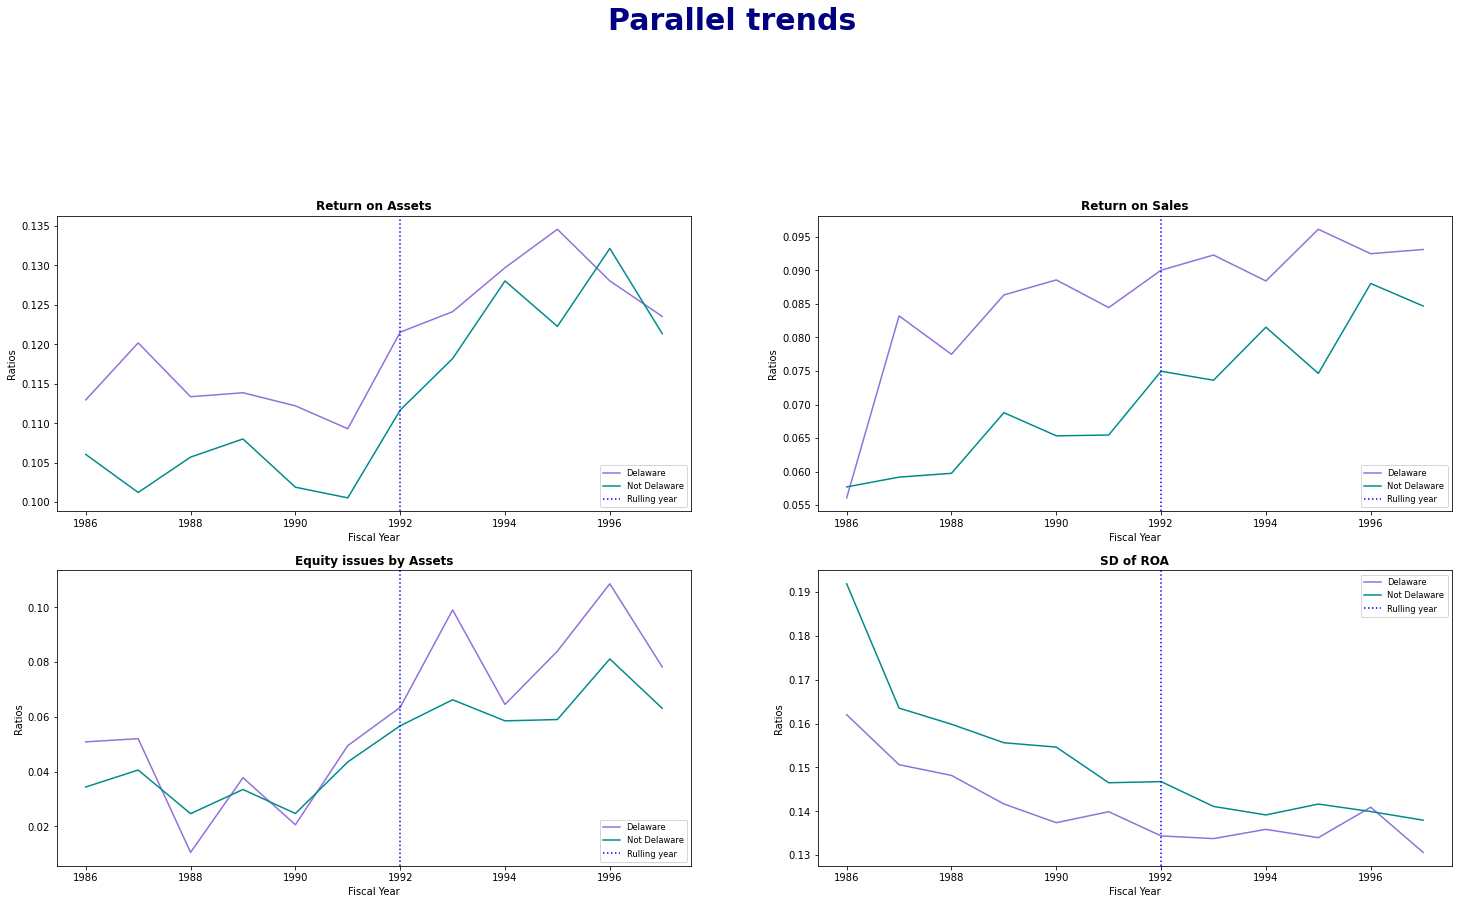

In [54]:
#Return on Assets
figure=plt.figure(figsize=(25, 25))

plt.suptitle('Parallel trends',fontsize=30, color = 'navy',va='bottom',fontweight="bold")
figure1 = figure.add_subplot(4,2,1)
figure1.set_title('Return on Assets',fontweight="bold")

DE_after = OLS_DF_Graphs[OLS_DF_Graphs['DE Dummy'] == 1] 
DE_after2 = pd.DataFrame(DE_after)
DE_after3=DE_after2.reset_index()
DE_after3=DE_after3.dropna()
DE_after3=DE_after3.groupby(['fyear']).mean('Return on Assets')
DE_after3=DE_after3.reset_index()
plt.plot(DE_after3['fyear'], DE_after3['Return on Assets'],label='Delaware', color='mediumpurple')
#plt.subplot(1, 1)

NDE_Before = OLS_DF_Graphs[OLS_DF_Graphs['DE Dummy'] == 0]   
NDE_Before2 = pd.DataFrame(NDE_Before)
NDE_Before3=NDE_Before2.reset_index()
NDE_Before3=NDE_Before3.dropna()
NDE_Before3=NDE_Before3.groupby(['fyear']).mean('Return on Assets')
NDE_Before3=NDE_Before3.reset_index()
plt.plot(NDE_Before3['fyear'], NDE_Before3['Return on Assets'],label='Not Delaware', color='darkcyan')
plt.axvline(x=1992.0 , color='b',ls=':', label='Rulling year')

plt.legend(loc='lower right',fontsize='small')
plt.ylabel("Ratios")
plt.xlabel("Fiscal Year")
#Return on Sales
figure2 = figure.add_subplot(4,2,2)
figure2.set_title('Return on Sales',fontweight="bold")

DE_after = OLS_DF_Graphs[OLS_DF_Graphs['DE Dummy'] == 1] 
DE_after2 = pd.DataFrame(DE_after)
DE_after3=DE_after2.reset_index()
DE_after3=DE_after3.dropna()
DE_after3=DE_after3.groupby(['fyear']).mean('Return on Sales')
DE_after3=DE_after3.reset_index()
plt.plot(DE_after3['fyear'], DE_after3['Return on Sales'],label='Delaware', color='mediumpurple')

NDE_Before = OLS_DF_Graphs[OLS_DF_Graphs['DE Dummy'] == 0]   
NDE_Before2 = pd.DataFrame(NDE_Before)
NDE_Before3=NDE_Before2.reset_index()
NDE_Before3=NDE_Before3.dropna()
NDE_Before3=NDE_Before3.groupby(['fyear']).mean('Return on Sales')
NDE_Before3=NDE_Before3.reset_index()

plt.ylabel("Ratios")
plt.xlabel("Fiscal Year")
plt.plot(NDE_Before3['fyear'], NDE_Before3['Return on Sales'],label='Not Delaware', color='darkcyan')
plt.axvline(x=1992.0 , color='b',ls=':', label='Rulling year')

plt.legend(loc='lower right',fontsize='small')
#Equity issues by assets
figure3 = figure.add_subplot(4,2,3)
figure3.set_title('Equity issues by Assets',fontweight="bold")
DE_after = OLS_DF_Graphs[OLS_DF_Graphs['DE Dummy'] == 1] 
DE_after2 = pd.DataFrame(DE_after)
DE_after3=DE_after2.reset_index()
DE_after3=DE_after3.dropna()
DE_after3=DE_after3.groupby(['fyear']).mean('Equity issues by assets')
DE_after3=DE_after3.reset_index()
plt.plot(DE_after3['fyear'], DE_after3['Equity issues by assets'],label='Delaware', color='mediumpurple')

NDE_Before = OLS_DF_Graphs[OLS_DF_Graphs['DE Dummy'] == 0]   
NDE_Before2 = pd.DataFrame(NDE_Before)
NDE_Before3=NDE_Before2.reset_index()
NDE_Before3=NDE_Before3.dropna()
NDE_Before3=NDE_Before3.groupby(['fyear']).mean('Equity issues by assets')
NDE_Before3=NDE_Before3.reset_index()
plt.ylabel("Ratios")
plt.xlabel("Fiscal Year")
plt.plot(NDE_Before3['fyear'], NDE_Before3['Equity issues by assets'],label='Not Delaware', color='darkcyan')
plt.axvline(x=1992.0 , color='b',ls=':', label='Rulling year')
plt.legend(loc='lower right',fontsize='small')
#SD of ROA
figure4 = figure.add_subplot(4,2,4)
figure4.set_title('SD of ROA',fontweight="bold")

DE_after = OLS_DF_Graphs[OLS_DF_Graphs['DE Dummy'] == 1] 
DE_after2 = pd.DataFrame(DE_after)
DE_after3=DE_after2.reset_index()
DE_after3=DE_after3.dropna()
DE_after3=DE_after3.groupby(['fyear']).mean('SD of ROA')
DE_after3=DE_after3.reset_index()
plt.plot(DE_after3['fyear'], DE_after3['SD of ROA'],label='Delaware', color='mediumpurple')

NDE_Before = OLS_DF_Graphs[OLS_DF_Graphs['DE Dummy'] == 0]   
NDE_Before2 = pd.DataFrame(NDE_Before)
NDE_Before3=NDE_Before2.reset_index()
NDE_Before3=NDE_Before3.dropna()
NDE_Before3=NDE_Before3.groupby(['fyear']).mean('SD of ROA')
NDE_Before3=NDE_Before3.reset_index()
plt.ylabel("Ratios")
plt.xlabel("Fiscal Year")
plt.plot(NDE_Before3['fyear'], NDE_Before3['SD of ROA'],label='Not Delaware', color='darkcyan')
plt.axvline(x=1992.0 , color='b',ls=':', label='Rulling year')
plt.legend(loc='upper right',fontsize='small')


**parallel trend** A parallel trend will allow us to see the change's impact visually (here the change was the ruling). Therefore, if they are exactly parallel before the ruling and they are no longer parallel after the ruling, we may simply conclude that the change was effective. However, in reality,  it would be difficult to anticipate a precisely comparable trend in such a massive subsample. However, there may still be some parallel trends and observable effects of the ruling.

**Return on Assets** and **Return on Sales**: These two graphs share a common feature in that they both showed a parallel trend for a short period of time prior to the ruling. For the first one (return on asset), the period of the parallel trend is longer than it is for the second one, which allows us to draw a more robust conclusion. Additionally, two years after the ruling, there was a significant difference between Delaware and non-Delaware firms, which may have been influenced by the 1992 ruling. To confirm that the shift in 1994 was caused by the ruling, we should take into account the causes of the changes in 1987. the same is true for sales returns. Prior to the ruling, there was a shorter parallel period, but there were also notable alterations after the ruling.

**Equity issues by Assets**:When trying to grasp a parallel trend, this graph is the one that stands out the most. The Delaware and non-Delaware subsamples showed a consistent trend previous to the ruling, but after the ruling, these trends showed significant disparities.It seems to fluctuate far more for Delaware-based businesses, experiencing peaks and valleys more quickly than those from other states. This also makes sense because the equity ratio is the most sensible percentage under this rule.

**Sd of row**: This graph is the one for which there was no parallel trend even the year prior to the ruling, therefore no conclusion can be drawn as to the impact of the ruling in this case.

# Question 2

### Question 2.1

##### **Using the same reasoning, explain (as concisely as possible) the following:**

#### Part A

**(a) what cross-sectional variation in leverage is**

In cross-sectional variation, we take into account the difference in leverage between the Delaware and non-Delaware firms and it enables us to comprehend the change in leverage over different firms at each specific moment (any time over different firms).

This will demonstrate the effects of the 1992 ruling on leverage in Delaware and elsewhere. In this case, our concern is related to the Delaware specifications compared to other firms and the result was that Investment and equity issues increase for the subsample of distressed firms in Delaware.

#### Part B

**(b) what time-series variation in leverage is**

In time series variation, we take into account the difference between firms' leverage before and after 1992(any firm over time) so that we will understand the result of the ruling on firms. 


#### Part C

**(c) whether you think the estimate in Becker and Stromberg (2012) is economically important or not**

0.66% <1 is considered as small economic effect but it is still significant. This coefficient estimate is 66 basis points, corresponding with approximately 4% of mean net leverage. And base on the table 6 of Becker and Stromberg (2012), it is significant at the 1% level. As it is also stated in Roberts and Sufi (2009), Covenant violations are associated with a gradual but persistent effect on leverage ratios because of the persistent decline in net debt issuances.
As a result, the modest amount supports the gradual effect, but the significance of it supports the long-lasting.


### Question 2.2

#### **What do you think I should do?”**
##### *Based on the empirical evidence in Becker and Stromberg (2012), and on what you know about agency problems, explain to Frank what you think about*

#### Part A

**(a) the expected effect of the announcement by Shedd on the firm’s stock price**

The stock price of Shedd Pharmaceuticals is expected to witness a reduction due to the announcement. This can be attributed to low distance-to-default, high leverage, and resultant high financial distress of the firm. Additionally, the announcement will serve as an information asymmetric tool, signalling that the company may be in financial distress or on the verge of going into financial distress. However, since this choice will lessen the issue of debt overhang and asset substitution, the long-term effects of reincorporating in Delaware on the price is not apparent. these reduction in the mentioned problems might even result in longer-term price increases. After the announcement, we are confident that the price will be reduced, but the long-term price is less certain.

#### Part B

**(b) the expected impact of the move on the firm’s ability to raise new capital and invest in new projects**

Investment increased after the ruling in Delaware relative to all firms and based on Becker and Stromberg (2012), it increased even more for firms close to bankruptcy. So, the expected impact for Shedd company after reincorporation in Delaware is increase in the investment.

In addition to an increase in investment, Shedd's ability to raise new capital will improve due to reduced financial distress costs resulting from decrease in debt overhang problem. Moreover, the reduction in the debt overhang problem will allow manager to be able to focus on investing on NPV positive project as new projects too. 


#### Part C

**(c) the reason why the CEO decided to move the firm to Delaware.**

The CEO, who is also a shareholder, wants to save the company, which is a difficult situation for him given that the company is heavily leveraged. According to Becker and Stromberg (2012), enterprises appear to have immediately benefited from lower agency costs by having easier access to borrow at more affordable rates. Due to increased fiduciary obligations, debt will be more affordable. In this company's scenario, risk shifting may occur because shareholders are willing to see their equity fall while debt holders' interest in the company rises. This could explain why the CEO is going to shift risks. In this way, if the company takes on more risk, the possible additional gains go to the shareholders while the downside risk is carried by the debt holders.